In [15]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append("C:/Users/Alberto/OneDrive - Aarhus universitet/Skrivebord/github/py-ls")
from lsFunctions import readRLS
from skimage import exposure
from scipy.linalg import eigh


In [16]:



def get_frame(data, frame_number):
    """
    Extracts a specified frame from the 3D ndarray data.

    Parameters:
        data (ndarray): The 3D data array from which to extract the frame.
        frame_number (int): The index of the frame to extract.

    Returns:
        ndarray: The extracted 2D frame.
    """
    if frame_number >= data.shape[2] or frame_number < 0:
        raise ValueError("Invalid frame number. It should be between 0 and {}.".format(data.shape[2]-1))
    return data[:,:,frame_number]

def display_frame(frame):
    """
    Pops up an interactive window displaying a 2D ndarray frame.

    Parameters:
        frame (ndarray): The 2D data frame to display.
    """
    # Define a custom red-blue colormap
    colors = [(0.9, 1, 0), (0.1, 0, 1)]  # R -> B
    n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
    cmap_name = 'custom_div_cmap'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=20)
    
    # Histogram equalization
    frame_equalized = exposure.equalize_hist(frame)
    
    plt.figure()
    plt.imshow(frame_equalized, cmap='cool')  # You can change the colormap if needed.
    plt.colorbar()
    plt.axis('off')  # to turn off axis numbers and ticks
    plt.show(block=True)  # block=True ensures the window stays open
    
def temporalContrastVect(data):
    start_time_normal = time.time()
    # Compute standard deviation along the time axis
    std_dev = np.std(data, axis=2)
    
    # Compute mean along the time axis
    mean_val = np.mean(data, axis=2)

    # Avoid potential division by zero by adding a small value to the denominator
    mean_val = np.where(mean_val == 0, 1e-10, mean_val)

    # Compute temporal contrast
    tContrast = std_dev / mean_val
    print("vectorized temporal contrast calculated in: --- %s seconds ---" % (time.time() - start_time_normal))
    return tContrast

def spatialContrastVect(data, kernel):
    start_time_optimized = time.time()

    # Shape of the resulting array after applying the kernel
    result_shape = (data.shape[0]-kernel+1, data.shape[1]-kernel+1, data.shape[2])

    # Use stride_tricks to create a windowed view on the data
    windowed_data = np.lib.stride_tricks.sliding_window_view(data, (kernel, kernel, 1))

    # Compute std and mean along the kernel dimensions (0 and 1)
    local_std = np.std(windowed_data, axis=(3, 4)).squeeze()
    local_mean = np.mean(windowed_data, axis=(3, 4)).squeeze()

    # Compute the spatial contrast
    sContrast = np.zeros(data.shape)
    sContrast[:result_shape[0], :result_shape[1], :] = local_std / local_mean

    print("spatial contrast calculated in: --- %s seconds ---" % (time.time() - start_time_optimized))
    return sContrast


def test_readRLS():
    path2numFive = "F:/Datos/Data_PhD_Alberto/data/dataFromNumberFive/20211213/baslerPulsatility/"
    nameFile = "20211213_4.rls"
    fileName = path2numFive + nameFile
    
    # Adjust the parameters as needed
    start_time_normal = time.time()
    data, sampling, timeStamps, sizeT = readRLS(fileName, 0, 200)
    print("Normal version: --- %s seconds ---" % (time.time() - start_time_normal))

    frame = get_frame(data, 1)
    popup_frame(frame)

    # Asserts or checks. For example:
    assert data is not None, "Data should not be None"
    assert len(timeStamps) == 200, "Expected 200 timestamps"

    print("All tests passed!")

In [17]:
path2numFive = "F:/Datos/Data_PhD_Alberto/data/dataFromNumberFive/20211213/baslerPulsatility/"
nameFile = "20211213_4.rls"
fileName = path2numFive + nameFile

# Adjust the parameters as needed
start_time_normal = time.time()
nFrames = 200
ROI = [[128,384],[400,800]]
data, sampling, timeStamps, sizeT = readRLS(fileName, 0, nFrames, ROI)
print("Read %s frames in: --- %s seconds ---" % (nFrames, time.time() - start_time_normal))

frame = get_frame(data, 1)

#display_frame(frame)

TypeError: type list doesn't define __round__ method

In [9]:
data.shape

(512, 1600, 200)

In [7]:
tLSCI = temporalContrastVect(data)

vectorized temporal contrast calculated in: --- 1.4487628936767578 seconds ---


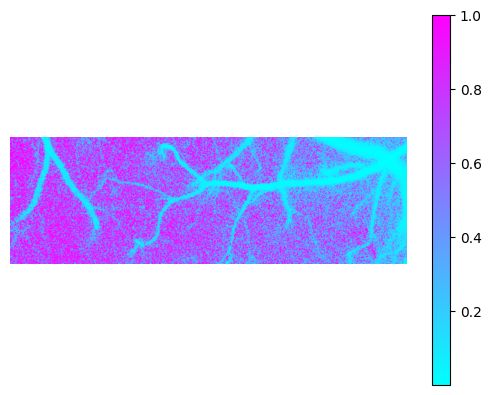

In [8]:
display_frame(tLSCI)

In [47]:
#sLSCI = spatialContrastVect(data,5)


In [73]:
def create_matrix_M(image_3d):
    """
    Convert a 3D image matrix into the data matrix M.
    
    image_3d: 3D numpy array with dimensions (height, width, time)
    
    Returns: 
    M: 2D numpy array with dimensions (height*width, time)
    """
    height, width, time = image_3d.shape
    M = image_3d.reshape(height * width, time)
    return M

def compute_covariance_matrix(M):
    """
    Compute the covariance matrix of M.
    
    M: Data matrix where each column is a time-series for a specific pixel.
    """
    T = M.shape[1]
    return (1/T) * np.dot(M, M.T)

def compute_small_covariance_matrix(M):
    """
    Compute the covariance matrix of M^T.
    
    M: Data matrix where each column is a time-series for a specific pixel.
    """
    T = M.shape[1]
    return (1/T) * np.dot(M.T, M)

def significant_eigenvectors(eigenvalues, threshold_factor=1.0):
    """
    Identify significant eigenvectors based on eigenvalues.
    
    Here, we consider eigenvalues greater than mean + threshold_factor * standard deviation as significant.
    """
    threshold = np.mean(eigenvalues) + threshold_factor * np.std(eigenvalues)
    significant_indices = np.where(eigenvalues > threshold)[0]
    return significant_indices

def eigen_decomposition(C):
    """
    Compute eigenvalues and eigenvectors of the covariance matrix C.
    """
    eigenvalues, eigenvectors = eigh(C)
    return eigenvalues[::-1], eigenvectors[:, ::-1]  # reverse to have in decreasing order


def reconstruct_dynamic_pattern(M, eigenvectors, significant_indices):
    """
    Reconstruct the dynamic interference pattern using significant eigenvectors.
    """
    significant_eigenvectors = eigenvectors[:, significant_indices]
    D = np.dot(M, significant_eigenvectors)
    return D


In [71]:
M = create_matrix_M(data)

In [94]:
M = create_matrix_M(data[0:5,0:5,:])

# compute_covariance_matrix or compute_small_covariance_matrix
C = compute_covariance_matrix(M)

# Eigenvalue Decomposition for the smaller matrix
eigenvalues, eigenvectors = eigh(C)

# Analyze Eigenvalue Distribution 
#significant_indices = significant_eigenvectors(eigenvalues)

# Relate eigenvectors of M^T M to those of M M^T
eigenvectors = np.dot(M.T, eigenvectors)
eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)  # normalize each eigenvector

# Reconstruction (keeping in mind the memory limits)
D = np.dot(M, eigenvectors) #[:, significant_indices])


In [100]:
eigenvalues

array([-3.20872859, -2.84529448, -2.34876601, -2.28384532, -2.12973792,
       -1.95745017, -1.65621634, -1.36634005, -0.91128242, -0.82252216,
       -0.58410982, -0.37588025, -0.24843847, -0.02768239,  0.35462098,
        0.63743028,  0.89683728,  1.04989635,  1.376704  ,  1.67777549,
        2.03865143,  2.45696466,  3.00613833,  3.47588223, 16.58539335])

2